In [1]:
print("hello world")

hello world


In [2]:
import os
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torchvision import transforms # .v2 as transforms
from torchvision.models import densenet121, DenseNet121_Weights
from torch.amp import GradScaler

# Local imports
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
# print(parent_dir)
tool_path = os.path.abspath(os.path.normpath(parent_dir))
if tool_path not in sys.path:
    sys.path.insert(0, tool_path)

from tools.data_tools import crop_image_tensor
from tools.model_tools import validate, train_and_test_model
from tools.visualization_tools import plot_training_statistics, print_training_statistics
from classes.RetinaDataset import RetinaDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Data Transformation & Augmentation

In [3]:
mean, std = pd.read_csv(os.path.join(parent_dir, 'data', 'mean-std', 'mean_std_256_256.csv'))['Mean'].values, pd.read_csv(os.path.join(parent_dir, 'data', 'mean-std', 'mean_std_256_256.csv'))['Std'].values

mean = np.array(mean, dtype=np.float32, copy=True)
std = np.array(std, dtype=np.float32, copy=True)

mean_tensor = torch.from_numpy(mean)
std_tensor = torch.from_numpy(std)

print(f"Mean: {mean_tensor}")
print(f"Std: {std_tensor}")

Mean: tensor([0.4493, 0.2722, 0.1405])
Std: tensor([0.2548, 0.1612, 0.0879])


densenet121 gets 256*256 tensors

In [4]:
# Appliquer les transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(crop_image_tensor),
    transforms.Resize((256, 256)), 
    transforms.Normalize(mean=mean, std=std)
])

# Single augmentation transform with random applications
transform_augmented = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(crop_image_tensor),
    transforms.Resize((256, 256)),
    transforms.RandomApply([
        transforms.RandomHorizontalFlip(p=1.0)
    ], p=0.5),
    transforms.RandomApply([
        transforms.RandomRotation(degrees=15)  # Reduced from 30 to preserve medical image integrity
    ], p=0.3),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
    ], p=0.3),
    transforms.Normalize(mean=mean, std=std)
])

## 2. Data Loading

In [5]:
train_dataset = RetinaDataset(
    root_dir='../../data/Training-Set/Training',
    csv_file='../../data/Training-Set/Training_Labels.csv',
    transform=transform_augmented,  # Use augmented transform with random applications
    type_of_classification='binary'
)

test_dataset = RetinaDataset(
    root_dir='../../data/Test-Set/Test',
    csv_file='../../data/Test-Set/Testing_Labels.csv',
    transform=transform,
    type_of_classification='binary'
)

val_dataset = RetinaDataset(
    root_dir='../../data/Evaluation-Set/Validation',
    csv_file='../../data/Evaluation-Set/Validation_Labels.csv',
    transform=transform,
    type_of_classification='binary'
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=5,
    pin_memory=True,
    persistent_workers=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=5,
    pin_memory=True,
    persistent_workers=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=5,
    pin_memory=True,
    persistent_workers=True
)

## 3. DenseNet121 definition

In [6]:
NUMBER_OF_LABELS = 1

model = densenet121(weights=DenseNet121_Weights.DEFAULT)
model.classifier = nn.Linear(model.classifier.in_features, NUMBER_OF_LABELS) 
model = model.to(device)

for param in model.parameters(): # first layers frozen
    param.requires_grad = False
for param in model.classifier.parameters(): # last layer trainable
    param.requires_grad = True

## 4. Loss definition

In [7]:
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([401 / 1519], device=device))  
# Adjust pos_weight as needed for class imbalance according to the EDA results

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)
scaler = GradScaler()  # For Automatic Mixed Precision

## 5. Model training

In [8]:
# Early stopping
patience = 5  
min_delta = 0.001  
best_test_loss = float('inf')
counter = 0

training_statistics = {
    'epoch': [],
    'train_losses': [],
    'test_losses': [],
    'train_accuracies': [],
    'test_accuracies': [],
    'test_f1s': [],
    'train_f1s': [],
    'train_roc_aucs': [],
    'test_roc_aucs': []
}

num_epochs = 30 

In [9]:
for epoch in range(num_epochs):
    print(f"Epoch number: {epoch}")

    # Training and evaluation
    train_loss, train_accuracy, train_f1, train_roc_auc, test_loss, test_accuracy, test_f1, test_roc_auc = train_and_test_model(
        model=model, 
        train_loader=train_loader,
        test_loader=test_loader,
        optimizer=optimizer, 
        criterion=criterion, 
        device=device,
        num_labels=NUMBER_OF_LABELS,
        scaler=scaler)
    
    # Print metrics
    print_training_statistics(
        train_loss, train_accuracy, train_f1, train_roc_auc, 
        test_loss, test_accuracy, test_f1, test_roc_auc,
        get_device_properties=True, memory_allocated=True, memory_reserved=True
    )

    scheduler.step(test_loss) 
    
    # Early stopping
    if epoch > 15:
        if (best_test_loss - test_loss) > min_delta:
            best_test_loss = test_loss
            counter = 0
        else:
            counter += 1
        if counter >= patience:
            print(f"Early stopping à l'epoch {epoch}")
            break

    # Metrics storage
    training_statistics['epoch'].append(epoch)
    training_statistics['train_losses'].append(train_loss)
    training_statistics['train_accuracies'].append(train_accuracy)
    training_statistics['train_f1s'].append(train_f1)
    training_statistics['train_roc_aucs'].append(train_roc_auc)
    training_statistics['test_losses'].append(test_loss)
    training_statistics['test_accuracies'].append(test_accuracy)
    training_statistics['test_f1s'].append(test_f1)
    training_statistics['test_roc_aucs'].append(test_roc_auc)



Epoch number: 0


100%|██████████| 15/15 [00:40<00:00,  2.73s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.2605 | Train Accuracy: 0.7083 | Train F1-score: 0.8007 | Train ROC-AUC: 0.7518 |
| Test Loss:  0.2404 | Test Accuracy:  0.5188 | Test F1-score:  0.5637 | Test ROC-AUC:  0.8955 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.04 Go          | cached: 2.41 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 1


100%|██████████| 15/15 [00:39<00:00,  2.61s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.2149 | Train Accuracy: 0.7547 | Train F1-score: 0.8266 | Train ROC-AUC: 0.8542 |
| Test Loss:  0.1791 | Test Accuracy:  0.8203 | Test F1-score:  0.8743 | Test ROC-AUC:  0.9320 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.04 Go          | cached: 2.41 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 2


100%|██████████| 15/15 [00:39<00:00,  2.63s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.1981 | Train Accuracy: 0.7583 | Train F1-score: 0.8295 | Train ROC-AUC: 0.8670 |
| Test Loss:  0.1592 | Test Accuracy:  0.8328 | Test F1-score:  0.8841 | Test ROC-AUC:  0.9396 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.04 Go          | cached: 2.41 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 3


100%|██████████| 15/15 [00:40<00:00,  2.68s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.1819 | Train Accuracy: 0.7865 | Train F1-score: 0.8509 | Train ROC-AUC: 0.8909 |
| Test Loss:  0.1516 | Test Accuracy:  0.7906 | Test F1-score:  0.8494 | Test ROC-AUC:  0.9440 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.04 Go          | cached: 2.41 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 4


100%|██████████| 15/15 [00:43<00:00,  2.93s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.1781 | Train Accuracy: 0.7875 | Train F1-score: 0.8513 | Train ROC-AUC: 0.8920 |
| Test Loss:  0.1441 | Test Accuracy:  0.8094 | Test F1-score:  0.8647 | Test ROC-AUC:  0.9462 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.04 Go          | cached: 2.41 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 5


100%|██████████| 15/15 [00:43<00:00,  2.92s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.1722 | Train Accuracy: 0.8016 | Train F1-score: 0.8618 | Train ROC-AUC: 0.9001 |
| Test Loss:  0.1409 | Test Accuracy:  0.8031 | Test F1-score:  0.8594 | Test ROC-AUC:  0.9493 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.04 Go          | cached: 2.41 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 6


100%|██████████| 15/15 [00:44<00:00,  2.98s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.1677 | Train Accuracy: 0.8047 | Train F1-score: 0.8642 | Train ROC-AUC: 0.9036 |
| Test Loss:  0.1345 | Test Accuracy:  0.8188 | Test F1-score:  0.8722 | Test ROC-AUC:  0.9506 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.04 Go          | cached: 2.41 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 7


100%|██████████| 15/15 [00:43<00:00,  2.93s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.1688 | Train Accuracy: 0.7990 | Train F1-score: 0.8599 | Train ROC-AUC: 0.8997 |
| Test Loss:  0.1312 | Test Accuracy:  0.8266 | Test F1-score:  0.8784 | Test ROC-AUC:  0.9518 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.04 Go          | cached: 2.41 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 8


100%|██████████| 15/15 [00:44<00:00,  2.98s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.1632 | Train Accuracy: 0.8047 | Train F1-score: 0.8646 | Train ROC-AUC: 0.9073 |
| Test Loss:  0.1312 | Test Accuracy:  0.8094 | Test F1-score:  0.8644 | Test ROC-AUC:  0.9532 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.04 Go          | cached: 2.41 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 9


100%|██████████| 15/15 [00:44<00:00,  2.99s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.1606 | Train Accuracy: 0.8099 | Train F1-score: 0.8689 | Train ROC-AUC: 0.9102 |
| Test Loss:  0.1344 | Test Accuracy:  0.8047 | Test F1-score:  0.8597 | Test ROC-AUC:  0.9532 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.04 Go          | cached: 2.41 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 10


100%|██████████| 15/15 [00:45<00:00,  3.02s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.1560 | Train Accuracy: 0.8188 | Train F1-score: 0.8748 | Train ROC-AUC: 0.9146 |
| Test Loss:  0.1285 | Test Accuracy:  0.8141 | Test F1-score:  0.8679 | Test ROC-AUC:  0.9541 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.04 Go          | cached: 2.41 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 11


100%|██████████| 15/15 [00:43<00:00,  2.92s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.1626 | Train Accuracy: 0.8193 | Train F1-score: 0.8765 | Train ROC-AUC: 0.9058 |
| Test Loss:  0.1415 | Test Accuracy:  0.7891 | Test F1-score:  0.8468 | Test ROC-AUC:  0.9547 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.04 Go          | cached: 2.41 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 12


100%|██████████| 15/15 [00:45<00:00,  3.02s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.1613 | Train Accuracy: 0.8125 | Train F1-score: 0.8699 | Train ROC-AUC: 0.9043 |
| Test Loss:  0.1262 | Test Accuracy:  0.8172 | Test F1-score:  0.8701 | Test ROC-AUC:  0.9554 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.04 Go          | cached: 2.41 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 13


100%|██████████| 15/15 [00:44<00:00,  2.93s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.1540 | Train Accuracy: 0.8089 | Train F1-score: 0.8665 | Train ROC-AUC: 0.9169 |
| Test Loss:  0.1174 | Test Accuracy:  0.8578 | Test F1-score:  0.9031 | Test ROC-AUC:  0.9561 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.04 Go          | cached: 2.41 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 14


100%|██████████| 15/15 [00:45<00:00,  3.01s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.1562 | Train Accuracy: 0.8208 | Train F1-score: 0.8773 | Train ROC-AUC: 0.9117 |
| Test Loss:  0.1231 | Test Accuracy:  0.8297 | Test F1-score:  0.8801 | Test ROC-AUC:  0.9568 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.04 Go          | cached: 2.41 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 15


100%|██████████| 15/15 [00:45<00:00,  3.02s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.1544 | Train Accuracy: 0.8229 | Train F1-score: 0.8784 | Train ROC-AUC: 0.9150 |
| Test Loss:  0.1242 | Test Accuracy:  0.8250 | Test F1-score:  0.8761 | Test ROC-AUC:  0.9575 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.04 Go          | cached: 2.41 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 16


100%|██████████| 15/15 [00:45<00:00,  3.06s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.1529 | Train Accuracy: 0.8161 | Train F1-score: 0.8727 | Train ROC-AUC: 0.9159 |
| Test Loss:  0.1170 | Test Accuracy:  0.8500 | Test F1-score:  0.8961 | Test ROC-AUC:  0.9576 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.04 Go          | cached: 2.41 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 17


100%|██████████| 15/15 [00:45<00:00,  3.02s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.1529 | Train Accuracy: 0.8260 | Train F1-score: 0.8805 | Train ROC-AUC: 0.9162 |
| Test Loss:  0.1166 | Test Accuracy:  0.8453 | Test F1-score:  0.8925 | Test ROC-AUC:  0.9583 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.04 Go          | cached: 2.41 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 18


100%|██████████| 15/15 [00:47<00:00,  3.15s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.1466 | Train Accuracy: 0.8271 | Train F1-score: 0.8814 | Train ROC-AUC: 0.9246 |
| Test Loss:  0.1161 | Test Accuracy:  0.8469 | Test F1-score:  0.8937 | Test ROC-AUC:  0.9585 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.04 Go          | cached: 2.41 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 19


100%|██████████| 15/15 [00:46<00:00,  3.12s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.1472 | Train Accuracy: 0.8229 | Train F1-score: 0.8775 | Train ROC-AUC: 0.9232 |
| Test Loss:  0.1149 | Test Accuracy:  0.8484 | Test F1-score:  0.8949 | Test ROC-AUC:  0.9588 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.04 Go          | cached: 2.41 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 20


100%|██████████| 15/15 [00:46<00:00,  3.08s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.1463 | Train Accuracy: 0.8333 | Train F1-score: 0.8868 | Train ROC-AUC: 0.9254 |
| Test Loss:  0.1188 | Test Accuracy:  0.8359 | Test F1-score:  0.8847 | Test ROC-AUC:  0.9589 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.04 Go          | cached: 2.41 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 21


100%|██████████| 15/15 [00:46<00:00,  3.10s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.1464 | Train Accuracy: 0.8271 | Train F1-score: 0.8813 | Train ROC-AUC: 0.9226 |
| Test Loss:  0.1207 | Test Accuracy:  0.8313 | Test F1-score:  0.8811 | Test ROC-AUC:  0.9592 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.04 Go          | cached: 2.41 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 22


100%|██████████| 15/15 [00:46<00:00,  3.08s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.1506 | Train Accuracy: 0.8172 | Train F1-score: 0.8741 | Train ROC-AUC: 0.9172 |
| Test Loss:  0.1236 | Test Accuracy:  0.8313 | Test F1-score:  0.8811 | Test ROC-AUC:  0.9594 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.04 Go          | cached: 2.41 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 23


100%|██████████| 15/15 [00:47<00:00,  3.14s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.1453 | Train Accuracy: 0.8156 | Train F1-score: 0.8711 | Train ROC-AUC: 0.9267 |
| Test Loss:  0.1176 | Test Accuracy:  0.8359 | Test F1-score:  0.8847 | Test ROC-AUC:  0.9593 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.04 Go          | cached: 2.41 Go       |
------------------------------------------------------------------------------------------------
Epoch number: 24


100%|██████████| 15/15 [00:47<00:00,  3.15s/it]


------------------------------------------------------------------------------------------------
| Train Loss: 0.1476 | Train Accuracy: 0.8193 | Train F1-score: 0.8755 | Train ROC-AUC: 0.9207 |
| Test Loss:  0.1146 | Test Accuracy:  0.8469 | Test F1-score:  0.8932 | Test ROC-AUC:  0.9595 |
| GPU VRAM checks -> | total: 15.92 Go        | used: 0.04 Go          | cached: 2.41 Go       |
------------------------------------------------------------------------------------------------
Early stopping à l'epoch 24


In [10]:
torch.save(model.state_dict(), '../Models/model_ft_densenet121_bc.pth')

In [11]:
training_statistics_df = pd.DataFrame(training_statistics)
training_statistics_df.to_csv('../Training-Statistics/ts_model_ft_densenet121_bc.csv', index=False)

## 6. Evolution of the training

In [12]:
training_statistics_df = pd.read_csv('../Training-Statistics/ts_model_ft_densenet121_bc.csv')

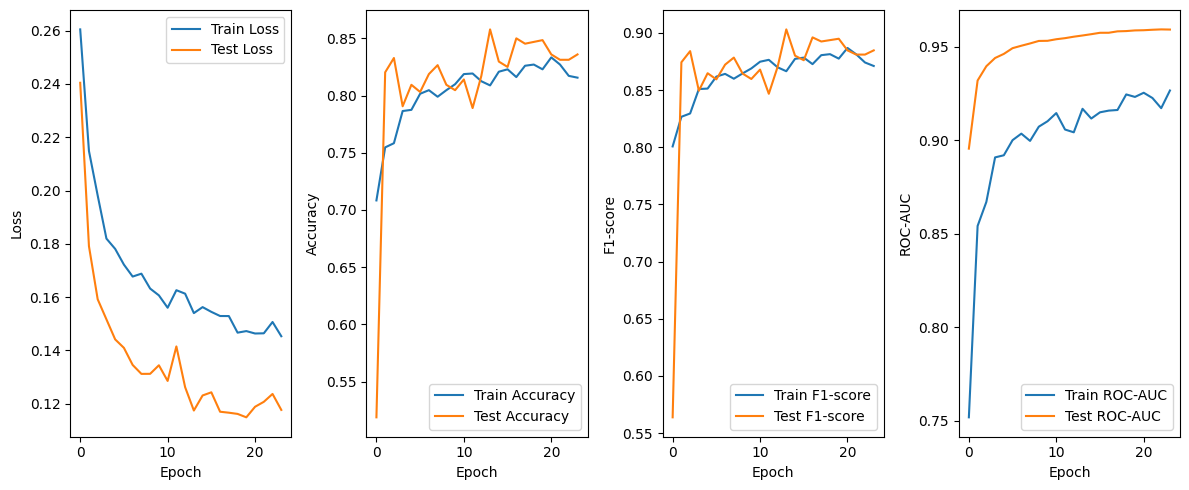

In [13]:
plot_training_statistics(
    training_statistics_df, 
    saving_path='../Training-Evolution-Images/te_model_ft_densenet121_bc_zoomed.png',
    title='Training Evolution - Fine Tuned DenseNet121 Binary Classification Zoomed',
    zoomed=True
)


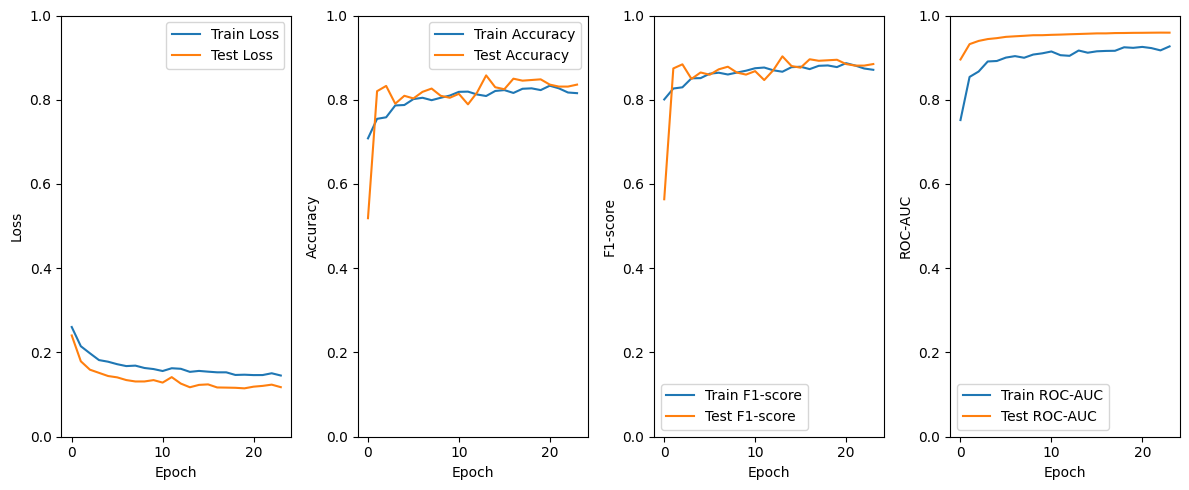

In [14]:
plot_training_statistics(
    training_statistics_df, 
    saving_path='../Training-Evolution-Images/te_model_ft_densenet121_bc.png',
    title='Training Evolution - Fine Tuned DenseNet121 Binary Classification',
    zoomed=False
)


## 7. Model evaluation

In [15]:
model = densenet121(weights=DenseNet121_Weights.DEFAULT)
model.classifier = nn.Linear(model.classifier.in_features, NUMBER_OF_LABELS) 
model = model.to(device) 
model.load_state_dict(torch.load('../Models/model_ft_densenet121_bc.pth', weights_only=True))
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([401 / 1519], device=device))  

In [16]:
val_loss, val_accuracy, val_f1, val_roc_auc = validate(model, val_loader, criterion, device=device, num_labels=NUMBER_OF_LABELS)

In [17]:
print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f} | Validation F1-score: {val_f1:.4f} | Validation ROC-AUC: {val_roc_auc:.4f}")

Validation Loss: 0.1345 | Validation Accuracy: 0.8391 | Validation F1-score: 0.8898 | Validation ROC-AUC: 0.9325
